In [1]:
%matplotlib inline

In [110]:
import pandas as pd
import os
import shutil
from Bio import SeqIO
from Bio import AlignIO
import distance
import editdistance
import math
import subprocess
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections
import pybedtools
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
from scipy.stats import pearsonr as pearsonr
from scipy.stats import fisher_exact

In [3]:
PAML_PATH = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/paml'
PROTEIN_DICT = {}
CDS_DICT = {}
PAIRING_DICT = {}
PROTEIN_DICT['DK0911'] = os.path.join(PAML_PATH, 'DK_0911_v04LT_ph_ctg.protein.fa')
PROTEIN_DICT['Pst104E'] = os.path.join(PAML_PATH, 'Pst_104E_v13_ph_ctg.protein.fa')
CDS_DICT['DK0911'] = os.path.join(PAML_PATH, 'DK_0911_v04LT_ph_ctg.cds.fa')
CDS_DICT['Pst104E'] = os.path.join(PAML_PATH, 'Pst_104E_v13_ph_ctg.cds.fa')
PAIRING_DICT['DK0911'] = os.path.join(PAML_PATH, 'DK.combined.paring')
PAIRING_DICT['Pst104E'] = os.path.join(PAML_PATH, 'PAu.combined.paring')
PAIRING_DICT['DK0911_ortho'] = os.path.join(PAML_PATH, 'DK.orthopairing')
PAIRING_DICT['Pst104E_ortho'] = os.path.join(PAML_PATH, 'PAu.orthopairing')
PAIRING_DICT['DK0911_synteny'] = os.path.join(PAML_PATH, 'DK.pairing')
PAIRING_DICT['Pst104E_synteny'] = os.path.join(PAML_PATH, 'PAu.pairing')


genomes = ['DK0911', 'Pst104E']
gene_keys = ['All_genes','Busco', 'Ceffectors',  'EffectorP',   'Secretome']
n_threads = 10

In [4]:
DK0911_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/DK0911_vs_Ps104E_v13/'
Pst_104E_ortho_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/Ps104E_v13_vs_DK0911/'
DK0911_genome_file_fn = '/home/benjamin/genome_assembly/Warrior/genome_v04/DK_0911_v04_ph_ctg.genome_file'
Pst_104E_genome_file_fn = \
'/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/092017_assembly/Pst_104E_v13_ph_ctg.genome_file'
WGA_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/mummer4'
LOWCOV_PAA_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_COV/SRM_mapping/filtered/'
ORTHOFINDER_FILE_NAME = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/result_update_redundant_protein_sets_01032019/Orthogroups_3_combined.csv'
OUT_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/downstream_analysis/'
ORTHOFINDER_FILE_NAME = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/orthofinder/result_update_redundant_protein_sets_01032019/Orthogroups_3_combined.csv'

In [5]:
###all the bedfiles
Pst_104E_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/Pst104E_annotations/'
Pst_104E_dict = {}
Pst_104E_dict['Busco'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.busco.gene.bed')
Pst_104E_dict['All_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.genes.gene.bed')
Pst_104E_dict['Primary_genes'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_p_ctg.genes.gene.bed')
Pst_104E_dict['Secretome'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.secretome.gene.bed')
Pst_104E_dict['Ceffectors'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.ceffectors.gene.bed')
Pst_104E_dict['EffectorP'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.effectorp.gene.bed')
Pst_104E_dict['TE_superfamily'] = os.path.join(Pst_104E_annotation_dir, 'Pst_104E_v13_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
Pst_104E_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'Pst_104E_v13_ph_ctg.bwamem.DK0911_gDNA.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed')
Pst_104E_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'Pst_104E_v13_ph_ctg.DK_0911_v04_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
Pst_104E_dict['Singletons'] = os.path.join(Pst_104E_ortho_dir,'190312_Ps104E_v13_vs_DK0911_singleton.csv')
Pst_104E_dict['Alleles'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_allele.csv')
Pst_104E_dict['Paraloges'] = os.path.join(Pst_104E_ortho_dir, '190312_Ps104E_v13_vs_DK0911_paraloge.csv')

In [6]:
###all the bedfiles
DK0911_annotation_dir = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations/'
DK0911_dict = {}
DK0911_dict['Busco'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.busco.gene.bed')
DK0911_dict['All_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.genes.gene.bed')
DK0911_dict['Primary_genes'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_p_ctg.genes.gene.bed')
DK0911_dict['Secretome'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.secretome.gene.bed')
DK0911_dict['Ceffectors'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['EffectorP'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.effectorp20.gene.bed')
DK0911_dict['TE_superfamily'] = os.path.join(DK0911_annotation_dir, 'DK_0911_v04_ph_ctg.104Ep_DK0911p.REPET.superfamily.gff')
DK0911_dict['Lowcov_01'] = os.path.join(LOWCOV_PAA_dir, 'DK_0911_v04_ph_ctg.bwamem.Pst79_TS.RG.mark_dup.ph_window_w1000s200.ph_mapping.lowcov01.filtered.bed' )
DK0911_dict['WGA_95'] = os.path.join(WGA_PAA_dir, 'DK_0911_v04_ph_ctg.Pst_104E_v13_ph_ctg.l100.c500.mm.deltafilter_i95mu0g_.nr_reverse.bed')
DK0911_dict['Singletons'] = os.path.join(DK0911_ortho_dir,'190506_DK0911_vs_Ps104E_v13_singleton.csv')
DK0911_dict['Alleles'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_allele.csv')
DK0911_dict['Paraloges'] = os.path.join(DK0911_ortho_dir, '190506_DK0911_vs_Ps104E_v13_paraloge.csv')

In [41]:
##OUTPATH for figures
OUTPATH='/home/benjamin/genome_assembly/Warrior/DK0911_v04/figures'

In [7]:
beddicts = [DK0911_dict, Pst_104E_dict]

In [8]:
def get_gene_list(bed_fn):
    df = pd.read_csv(bed_fn, header=None, sep='\t')
    return df[3].unique()

In [9]:
def getFastaDict(fastaFile):
    d = {}
    for gene in SeqIO.parse(fastaFile, 'fasta'):
        d[gene.id] = gene
    return d

In [10]:
def writeAllelicFasta(alleleOne, alleleTwo, alleleType, fa_dict, outPath):
    '''writes fasta file containing fasta information for two alleles
    in the outPath'''
    assert(alleleType.upper() in ['CDS', 'GENE', 'PROTEIN'])
    
    alleleSeqRecords = []
    alleleSeqRecords.append(fa_dict[alleleOne])
    alleleSeqRecords.append(fa_dict[alleleTwo])
    
    with open(os.path.join(outPath, alleleType.lower() + '.fa'), 'w') as outFile:
        SeqIO.write(alleleSeqRecords, outFile, 'fasta')
    return True

def writeAlignmentScript(alleleOutPath, scriptLoc):
    with open(scriptLoc, 'a') as outFile:
        print('cd %s' % alleleOutPath, file=outFile)
        print('muscle -clwstrict -in protein.fa -out protein.aln', file=outFile)
        print('perl /home/benjamin/anaconda3/orthologr/inst/pal2nal/pal2nal.v14/pal2nal.pl -output paml protein.aln cds.fa > cds_codon.aln', file=outFile)
        print('perl /home/benjamin/anaconda3/orthologr/inst/pal2nal/pal2nal.v14/pal2nal.pl protein.aln cds.fa > cds_codon.clustal', file=outFile)
        print('cp %s/yn00.ctl ./' % PAML_PATH, file=outFile)
        print('yn00', file=outFile)
    return True

In [11]:
def prepareAlignmentBashScript(pairing_fn, protein_dict, cds_dict, script_fn, OUT_PATH):
    with open(script_fn, 'w') as pamlScript:
        print('#!/bin/bash', file=pamlScript)
    
    df = pd.read_csv(pairing_fn, sep='\t', header=None, names=['Query', 'Target'])
    
    for index, [Query, Target] in df.iloc[:, :2].iterrows():

        alleleOutPath = os.path.join(OUT_PATH, '%s_%s' % (Query, Target))
        if not os.path.exists(alleleOutPath):
            os.mkdir(os.path.join(OUT_PATH, '%s_%s' % (Query, Target)))

        writeAllelicFasta(Query, Target, 'CDS', cds_dict, alleleOutPath)
        writeAllelicFasta(Query, Target, 'PROTEIN', protein_dict, alleleOutPath)

        writeAlignmentScript(alleleOutPath, script_fn)
    return True

In [12]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return it.zip_longest(*args, fillvalue=fillvalue)

In [13]:
def combineTmpToDf(header, suffix, tmp_path, clean=True):
    """Combines the files of a temporary folder into a dataframe based on the tmp files
    suffix. Returns combined dataframe. And cleans up if needed."""
    tmp_assigneddfs_fh = [os.path.join(tmp_path, file) for file in os.listdir(tmp_path)\
                         if file.endswith(suffix) ]
    print(len(tmp_assigneddfs_fh))
    tmp_df = pd.DataFrame(columns=header)
    for df_fh in tmp_assigneddfs_fh:
        tmp_df = pd.concat([tmp_df, pd.read_csv(df_fh, index_col = 0, sep='\t')])
    if clean == True:
        #now clean up again
        for file in tmp_assigneddfs_fh:
            os.remove(file)
    return tmp_df

In [14]:
def assignDistancesToAlleles(folder, alignmentFile, alleleType):
    '''Adds Hamming and Levenshtein distance columns to an allele pair
    (indexed by 'folder' name) in df'''
    #print(folder)
    if pd.isnull(folder):
        return np.nan, np.nan
    assert(alleleType.upper() in ['PROTEIN', 'CDS', 'GENE'])
    seq1, seq2 = AlignIO.read(open(alignmentFile, 'r'), format='clustal', seq_count=2)
    seq1 = str(seq1.seq).upper()
    seq2 = str(seq2.seq).upper()
    assert(len(seq1) == len(seq2))
    return editdistance.eval(seq1, seq2)/len(seq1), distance.hamming(seq1, seq2, normalized=True)

def assignDistancesToAllAlleles(df_folder_index, all_folders, tmp_path, base_path, suffix):
    """
    Reads in the index that contains the folder pairings for the alignements.
    Returns a protein_df and CDS_df that contain the hamming and levenshtein distance each.
    """
    cleaned_index = [x for x in df_folder_index if x in all_folders]
    count = 0
    total = len(df_folder_index)
    percentDone = 0
    protein_lev_dict = {}
    protein_ham_dict = {}
    CDS_lev_dict = {}
    CDS_ham_dict = {}
    
    #print("Calculating distances and adding them to the allele DataFrame...")
    
    for folder in cleaned_index:
        if pd.isnull(folder):
            proteinAlignmentFile = ''
            cdsAlignmentFile = ''
        else:
            proteinAlignmentFile = os.path.join(base_path, folder, 'protein.aln')
            cdsAlignmentFile = os.path.join(base_path, folder, 'cds_codon.clustal')
        #here the nan get overwritten. This doesn't matter though as they are all
        #nan anyway.
        protein_lev_dict[folder], protein_ham_dict[folder]  = \
        assignDistancesToAlleles(folder, proteinAlignmentFile, 'PROTEIN')
        CDS_lev_dict[folder], CDS_ham_dict[folder]  = \
        assignDistancesToAlleles(folder, cdsAlignmentFile, 'CDS')

        count += 1
        #if round(count/total * 100) > percentDone:
            #percentDone = round(count/total * 100)
            #print("%s%% complete" % percentDone)
            
    newdf_columns=['protein_hamming', 'protein_levenshtein', 'cds_hamming',
       'cds_levenshtein']
    if len(protein_ham_dict) > 0:
        df = pd.DataFrame([protein_ham_dict,protein_lev_dict,CDS_ham_dict,CDS_lev_dict]).T
        df.rename(columns=dict(zip(df.columns,newdf_columns)),inplace=True)
        out_name = os.path.join(tmp_path, '%s_%s.%s' % (df.index[0],df.index[-1],suffix))
        df.round(4).to_csv(out_name, sep='\t')

In [15]:
def parse_dNdS_to_df(line, folder):
    """
    Function that parses out dN and dS of a yn00 file and calls the 
    assign_dNdS function. Therefore returns a single element
    pd.Series with folder name as index.
    """
    dN = re.findall(r'dN = [-| ]?(.*) w', line)[0]
    dS = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
    return assign_dNdS(dN, dS, folder)

def assign_dNdS(dN, dS, folder):
    '''
    Function that cacluates the dN/dS ratio an returns it as a series usind the folder as index.
    Input: dN, dS, folder(name)
    Output: single element pd.Series with folder name as index.
    '''
    if float(dS) > 0:
        series = pd.Series([float(dN)/float(dS)], index=[folder])
    else:
        series = pd.Series([np.nan], index=[folder])
    return series

def assign_dNdS_to_all_alleles(folder_index, all_folders, tmp_path, base_path, suffix):
    """Function that parses out the different dN/dS ratios from a yn.out file for a list/index
    of folders that contain these yn.out files. The output dataframe is saved to tmp folder using
    the suffix.
    Input:  folder_index, list or index where to find the yn.out for each pairing.
            all_folders, are all possible folders. This is used to filter out nan and so from
                paralizing etc.
            tmp_path, is the path were 
    Output: Saved out tmp df with the suffix as file ending.
    
    """
    cleaned_index = [x for x in folder_index if x in all_folders]
    #print(cleaned_index)
    yn00_s = pd.Series([], name='yn00_dN/dS')
    LWL85_s = pd.Series([], name='LWL85_dN/dS')
    LWL85m_s = pd.Series([], name='LWL85m_dN/dS')
    LPB93_s = pd.Series([], name='LPB93_dN/dS')
    #header = ['folder','yn00_dN/dS', 'LWL85_dN/dS','LWL85m_dN/dS','LPB93_dN/dS']
    #append these list
    for folder in cleaned_index:
        alleleYn = os.path.join(base_path, folder,'yn.out')
        with open(alleleYn, 'r') as ynOut:
            #now loop over the lines and parse out stuff
            for i, line in enumerate(ynOut):
                if line.startswith('seq. seq. ') and i > 0:
                    next(ynOut) # we want the line that is two after the line starting with 'seq. seq '
                    dataLine = next(ynOut)
                    dN = dataLine.split('+-')[0].rstrip().split(' ')[-1]
                    dS = dataLine.split('+-')[1].rstrip().split(' ')[-1]
                    yn00_s = yn00_s.append(assign_dNdS(dN, dS, folder))
                elif line.startswith('LWL85:') and 'nan' not in line:
                    LWL85_s = LWL85_s.append(parse_dNdS_to_df(line, folder))
                elif line.startswith('LWL85m:') and 'nan' not in line:
                    LWL85m_s= LWL85m_s.append(parse_dNdS_to_df(line, folder))
                elif line.startswith('LPB93:') and 'nan' not in line:
                    LPB93_s =LPB93_s.append(parse_dNdS_to_df(line, folder))
                else:
                    continue
    out_df = pd.concat([yn00_s.round(4),LWL85_s.round(4),\
                        LWL85m_s.round(4), LPB93_s.round(4)],axis =1)
    new_columns = ['yn00_dN/dS','LWL85_dN/dS','LWL85m_dN/dS','LPB93_dN/dS' ]
    if len(out_df) > 0:
        out_df.rename(columns=dict(zip(out_df.columns, new_columns)), inplace=True)
        out_name = os.path.join(tmp_path, '%s_%s.%s' % (out_df.index[0],out_df.index[-1],suffix))
        out_df.to_csv(out_name, sep='\t')
    #return out_df

In [16]:
def add_gentype_column(df, gene_type_list, genome, bed_fn_dict):
    """A function that takes a collinear dataframe, a gentype list, a genome name and a dictionary
    that contains the filenames for bedfiles of genes belonging to different genetypes.
    The function adds a new column to the df with False/True to belonging to the genetype."""
    for gene_type in gene_type_list:
        tmp_index = df[genome].isin(get_gene_list(bed_fn_dict[gene_type]))
        key = '%s_%s' % (genome, gene_type)
        df[key] = False
        df.loc[tmp_index, key] = True
    return df

In [39]:
def plot_variation(genome, df, value, y_label,  color, out_fn):
   
    columns = [x for x in df.columns if genome in x][1:]
    
    f1, ax = plt.subplots(1, len(columns), figsize=(20, 7), sharey=True)
    
    column_rename_dict = {'All_genes': 'All genes',
                         'Busco': "BUSCOs",
                         'Ceffectors': 'Candidate effectors',
                         'EffectorP' : 'EffectorP',
                         'Secretome' : 'Secretome'}
    
    
    for n, column in enumerate(columns):
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst104E':
            _dict = Pst_104E_dict
    
        max_genes = len(get_gene_list(_dict[column.replace(genome+'_','')]))
        
        
        sns.violinplot(y=df[df[column] == True][value], color=color, ax=ax[n], cut =0)

        ax[n].set_ylabel('')
        ax[n].set_xlabel(column_rename_dict[column.replace(genome+"_",'')]\
                         , fontsize=20, fontweight='bold')
        
        y_text_start_value = df[value].max()
        
        ax[n].text(0.1, y_text_start_value, 'n=%s' % df[(df[value] > 0)&(df[column] ==True)].shape[0])
        
        
        
        ax[n].text(0.1, 0.9*y_text_start_value, 'max=%s' % max_genes)
        percentage = round(df[(df[value] > 0)&(df[column] ==True) ].shape[0]/max_genes*100,2)
        ax[n].text(0.1, 0.8*y_text_start_value, '%%=%s' % percentage)
    
    
        for axis in ['bottom','left']:
            ax[n].spines[axis].set_linewidth(2)
        for axis in ['top','right']:
            ax[n].spines[axis].set_linewidth(0)
        ax[n].tick_params(width=2)
    
    
    
    
    ax[0].set_ylabel(y_label, fontsize=20, fontweight='bold')

    plt.subplots_adjust(right=0.3, left=0.1)

    plt.tight_layout()

    sns.despine(f1)
    return f1

In [17]:
protein_dict = {}
for genome in genomes:
    protein_dict.update(getFastaDict(PROTEIN_DICT[genome]))

In [18]:
cds_dict = {}
for genome in genomes:
    cds_dict.update(getFastaDict(CDS_DICT[genome]))

In [19]:
for genome in genomes:
    BASE_OUT = os.path.join(PAML_PATH, genome)
    if not os.path.exists(BASE_OUT):
        os.makedirs(BASE_OUT)
    paml_script_fn = os.path.join(BASE_OUT, 'paml_script.sh')
    prepareAlignmentBashScript(PAIRING_DICT[genome], protein_dict, cds_dict, paml_script_fn, BASE_OUT)

#### Execute both paml scripts on the command line

In [20]:
GENEMATCHDICT = {}
for genome in genomes:
    BASE_OUT = os.path.join(PAML_PATH, genome)
    if not os.path.exists(BASE_OUT):
        os.makedirs(BASE_OUT)
        
    #prepare the genematch dataframe    
    genematchDf = pd.read_csv(PAIRING_DICT[genome], sep='\t',\
                              header=None, names=['Query', 'Target'])
    genematchDf['folder'] = genematchDf.Query +'_' + genematchDf.Target
    genematchDf.set_index('folder', inplace=True)
    
    analysedAllelesPath = os.path.join(BASE_OUT, genome+'_analysed_genematch.df') 
    GENEMATCHDICT[genome] = analysedAllelesPath
    all_folders = genematchDf.index
    #generate a tmp folder for the parallized analysis
    tmp_path = os.path.join(BASE_OUT, 'tmp')
    if not os.path.exists(tmp_path):
        os.mkdir(tmp_path)
    #assign the distances
    dist_suffix = 'distdf_tmp'
    Parallel(n_jobs=n_threads)(delayed(assignDistancesToAllAlleles)\
                (list(folder_index_list),all_folders,tmp_path, BASE_OUT, dist_suffix)\
                       for folder_index_list in grouper(genematchDf.index, 100, np.nan))
    distdf_header = ['protein_hamming', 'protein_levenshtein', 'cds_hamming',
       'cds_levenshtein']
    distdf = combineTmpToDf(distdf_header, dist_suffix, tmp_path, clean=True)
    distdf['Index'] = distdf.index
    genematchDf['Index'] = genematchDf.index
    tmp_df = pd.merge(genematchDf, distdf,how='inner')
    tmp_df.to_csv(analysedAllelesPath, sep='\t')
    print("Done with caculate pairwise alignment distances.")
    #pd.util.testing.assert_frame_equal(alleleDf, pd.read_csv(analysedAllelesPath, sep='\t', index_col=0))
    print("Starting to parse dN/dS ratios from yn.out file.")
    
    dNdS_suffix = 'dNdSdf_tmp'
    #now assign the dNdS ratios
    Parallel(n_jobs=n_threads)(delayed(assign_dNdS_to_all_alleles)\
                        (list(folder_index_list),all_folders,tmp_path, BASE_OUT, dNdS_suffix)\
                       for folder_index_list in grouper(genematchDf.index, 100, np.nan))
    dNdS_header = ['yn00_dN/dS','LWL85_dN/dS','LWL85m_dN/dS','LPB93_dN/dS' ]
    dNdSdf = combineTmpToDf(dNdS_header, dNdS_suffix, tmp_path, clean=True)
    dNdSdf['Index'] = dNdSdf.index
    tmp_df = pd.merge(tmp_df, dNdSdf,how='inner')
    tmp_df.to_csv(analysedAllelesPath, sep='\t')
    print('Finish to parse dN/dS ratios.')

248
Done with caculate pairwise alignment distances.
Starting to parse dN/dS ratios from yn.out file.


/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pa

248
Finish to parse dN/dS ratios.
290
Done with caculate pairwise alignment distances.
Starting to parse dN/dS ratios from yn.out file.


/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pa

290
Finish to parse dN/dS ratios.


In [ ]:
#looking good now add the gene categories and if the genes are from synteny or orthology

In [21]:
GENEMATCHDFDICT = {}

In [22]:
for genome, bed_dict in zip(genomes, beddicts):

    tmp_df = pd.read_csv(GENEMATCHDICT[genome], sep='\t')
    tmp_df.drop(['Index', 'Unnamed: 0'], inplace=True, axis=1)

    if genome == 'DK0911':
        tmp_df.rename(columns=dict(zip(['Query', 'Target'], genomes)), inplace=True)
    elif genome == 'Pst104E':
        genomes.reverse()
        tmp_df.rename(columns=dict(zip(['Query', 'Target'], genomes)), inplace=True)
        genomes.reverse()
    
    missing_genes = set(get_gene_list(bed_dict["All_genes"])) - set(tmp_df[genome])
    addondf = pd.DataFrame(columns=tmp_df.columns)
    addondf[genome] = pd.Series(list(missing_genes))
    tmp_df = pd.concat([tmp_df, addondf])
    tmp_df.reset_index(drop=True, inplace=True)
    
    for cgenome in genomes:
        tmp_df = add_gentype_column(tmp_df, gene_keys, cgenome, bed_dict)
    
    tmp_df['Match_type'] = None
    for matchtype in ['ortho' , 'synteny']:
        tmp_index = tmp_df[tmp_df[genome]\
                           .isin(pd.read_csv(PAIRING_DICT[genome+'_'+matchtype], header=None, sep='\t')\
                                 [0].tolist())].index
        tmp_df.loc[tmp_index, 'Match_type'] = matchtype
    
    
    GENEMATCHDFDICT[genome] = tmp_df
genomes = ['DK0911', 'Pst104E']

In [23]:
GENEMATCHDFDICT['Pst104E']['Match_type'].unique()

array(['ortho', 'synteny', None], dtype=object)

In [24]:
GENEMATCHDFDICT['Pst104E'].tail()

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
30244,Pst104E_08225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None
30245,Pst104E_27698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None
30246,Pst104E_25582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None
30247,Pst104E_12863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None
30248,Pst104E_18742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,None


In [25]:
tmp_df.head()

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
0,Pst104E_18206,DK0911_30030,0.8480,0.8480,0.8423,0.8397,0.7592,0.7774,0.7307,0.7776,...,False,False,False,False,True,False,False,False,False,ortho
1,Pst104E_29488,DK0911_06256,0.2134,0.2134,0.1636,0.1616,0.3598,0.3006,0.3261,0.3828,...,False,False,False,False,True,False,False,False,False,ortho
2,Pst104E_25028,DK0911_13770,0.8104,0.8104,0.8104,0.8104,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho
3,Pst104E_28456,DK0911_12480,0.6893,0.6893,0.6610,0.6573,0.3860,0.3324,0.4684,0.3753,...,False,False,False,False,True,False,False,False,False,ortho
4,Pst104E_06991,DK0911_26923,0.7500,0.7500,0.7280,0.7198,0.2355,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho


In [26]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

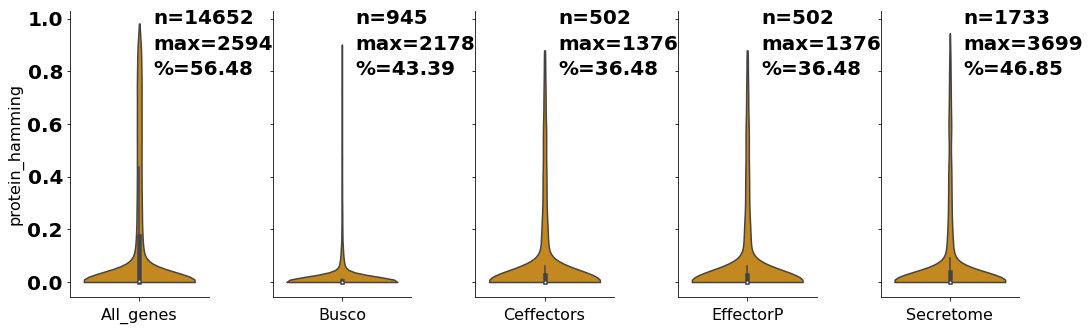

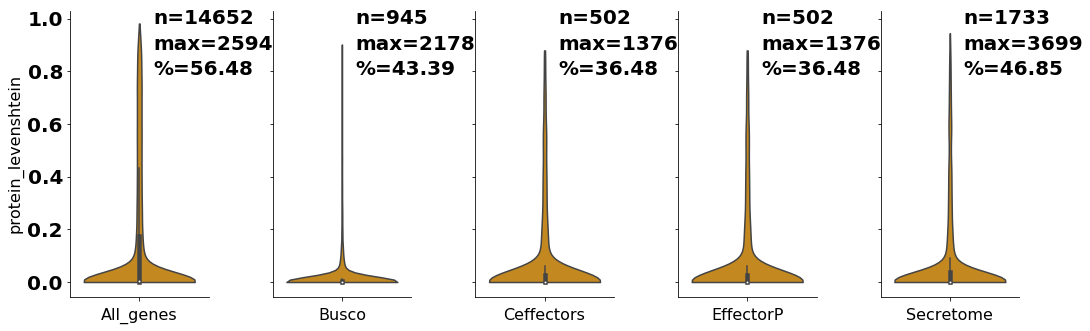

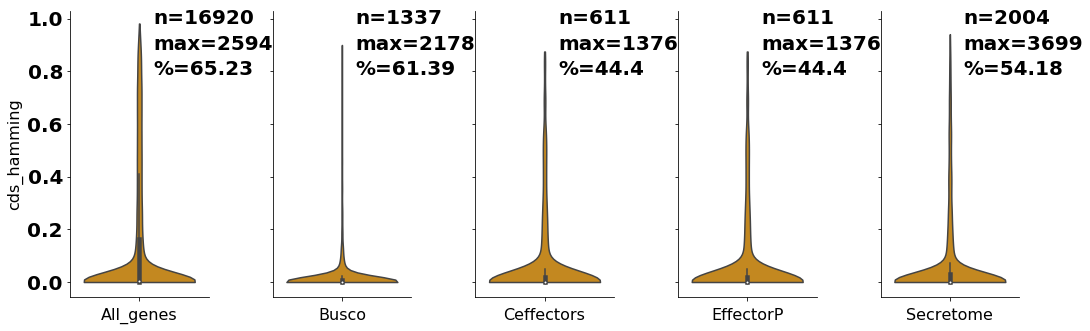

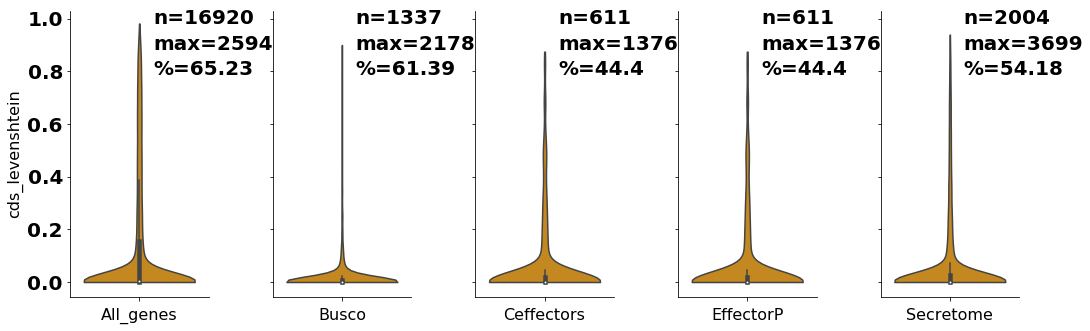

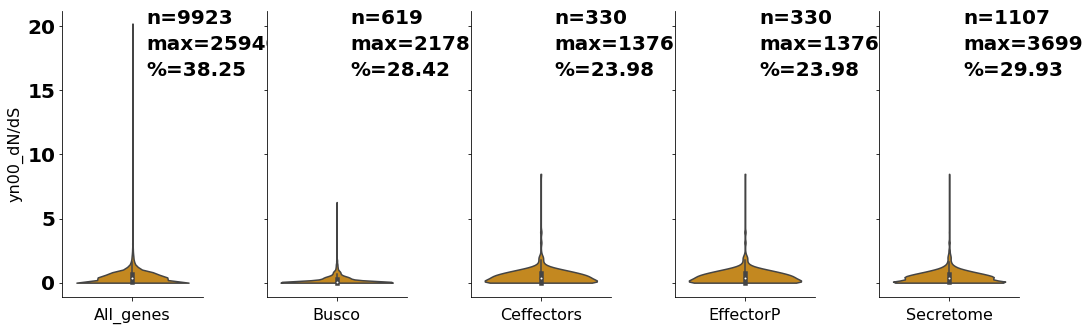

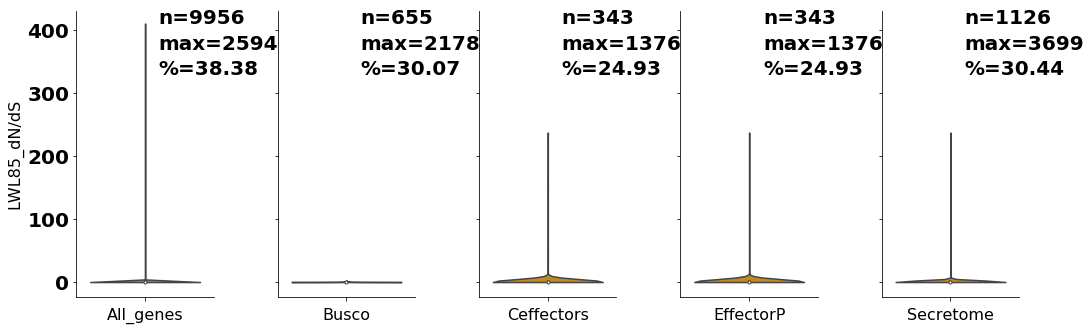

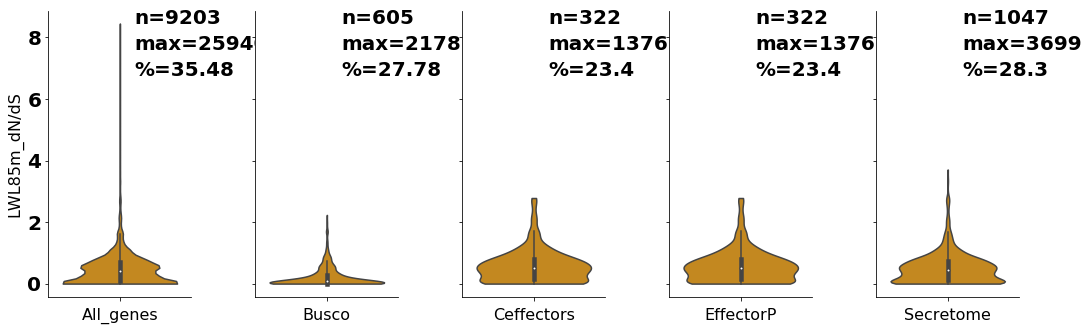

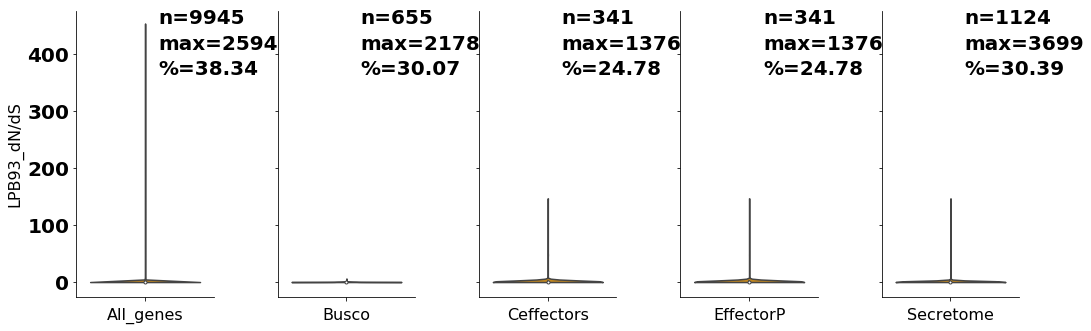

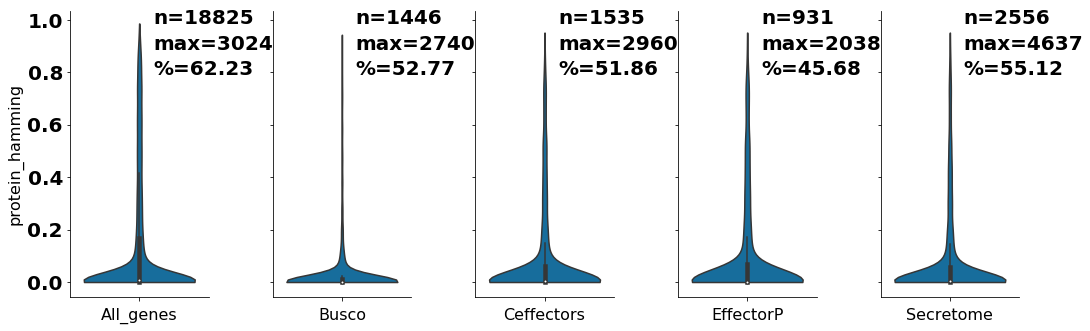

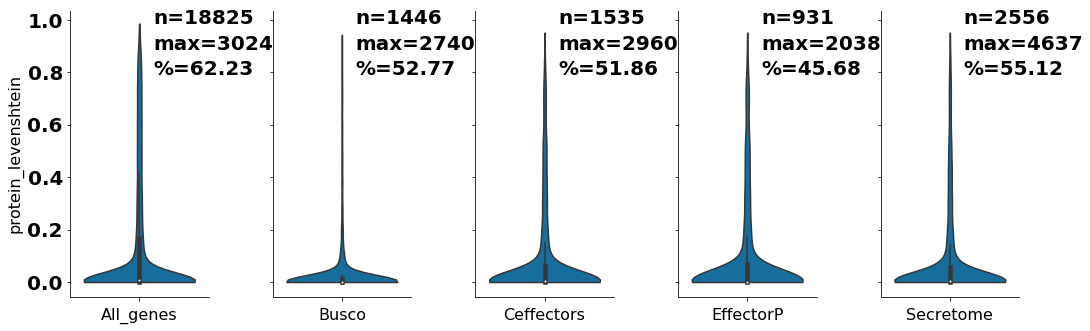

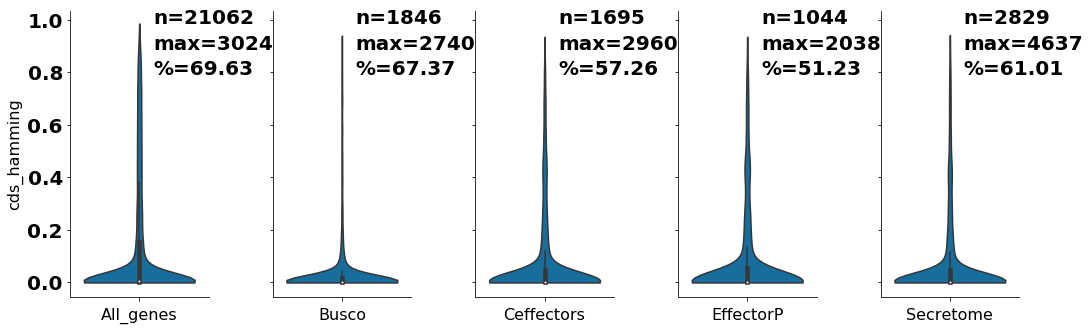

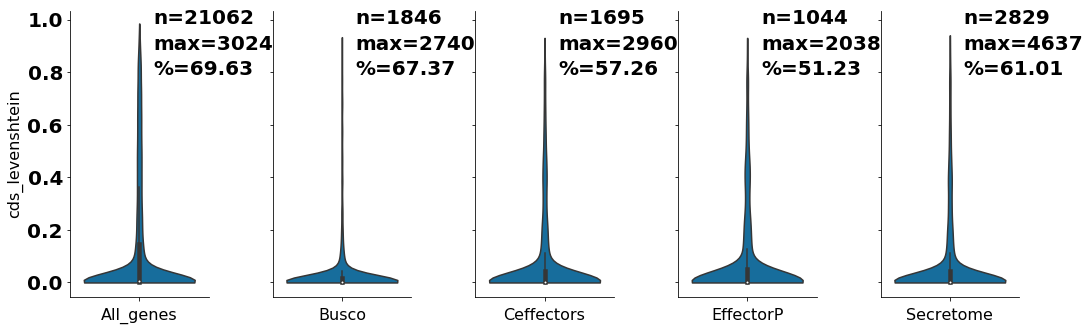

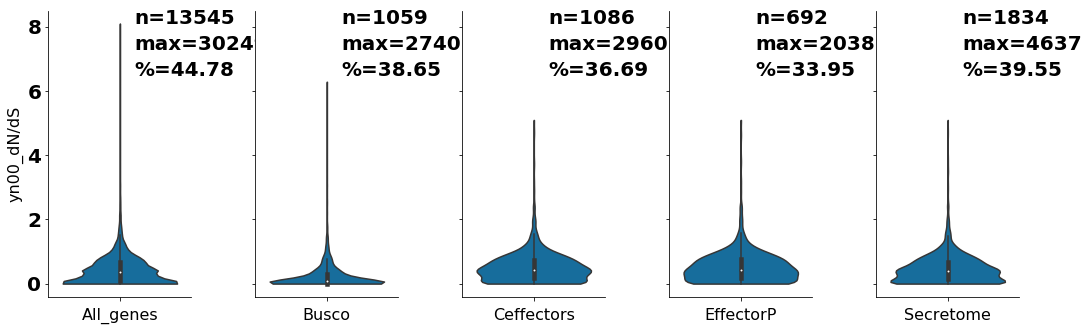

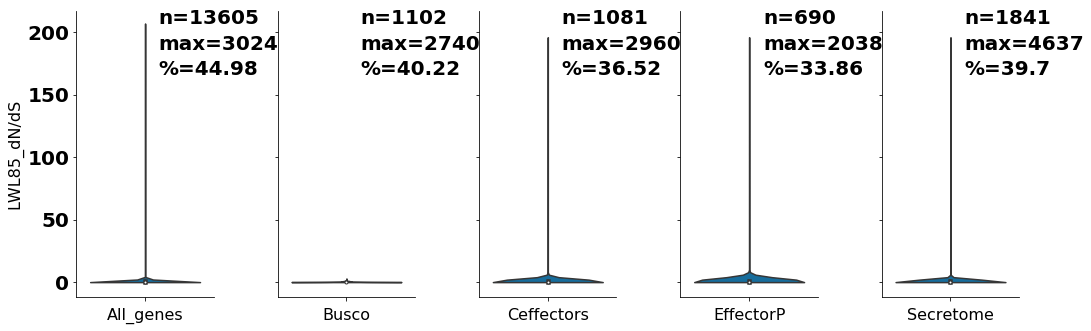

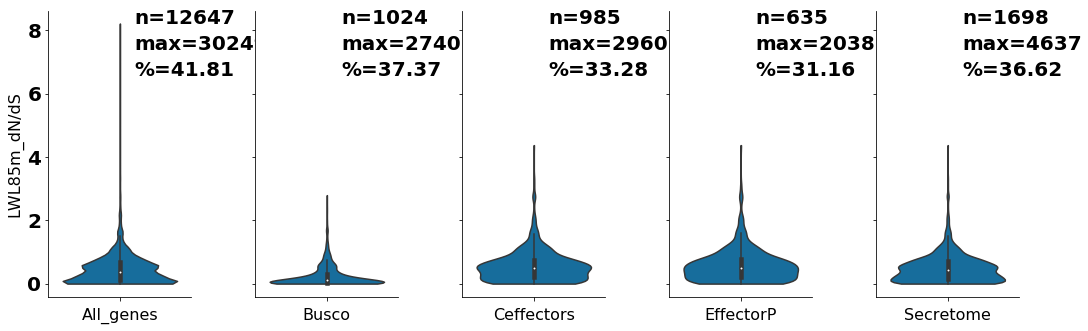

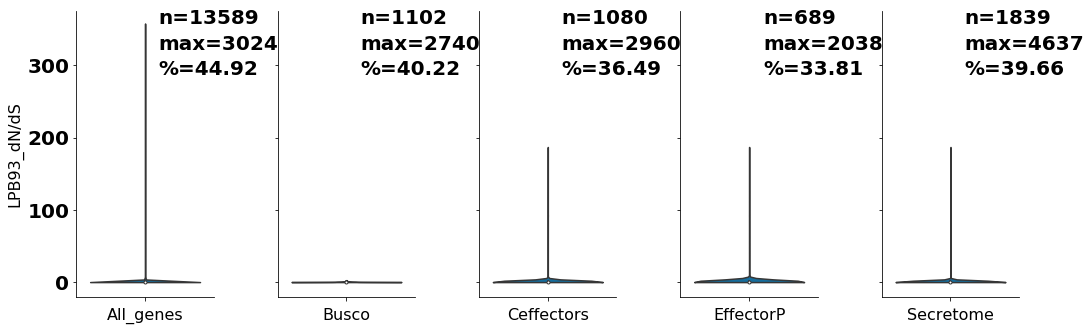

In [28]:
pallete = [sns.color_palette('colorblind')[x] for x in [1,0]]

#needs fixing for the n calculation
#think about variation and synteny block length or gaps. This might be interesting.


for genome, color, genome_dict in zip(genomes, pallete, beddicts): 
    tmp_df = GENEMATCHDFDICT[genome]
    columns = [x for x in tmp_df.columns if x.startswith(genome + '_')]
    value_columns = ['protein_hamming', 'protein_levenshtein',
       'cds_hamming', 'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS',
       'LWL85m_dN/dS', 'LPB93_dN/dS']
    for n, value in enumerate(value_columns):
        tmp_df_columns = []
        tmp_df_columns.append(genome)
        tmp_df_columns.append(value)
        tmp_df_columns.append('Match_type') 
        tmp_df_columns = tmp_df_columns + columns
        #tmp_df = tmp_df.loc[:, tmp_df_columns]
        #tmp_df = tmp_df[tmp_df.value]
        plot_variation(genome, tmp_df.loc[:, tmp_df_columns], value, value,  color, 'something')

In [126]:
genomes

['DK0911', 'Pst104E']

In [129]:
print('Hello')

Hello


In [169]:
from collections import OrderedDict as OD
from scipy.stats import kruskal as kruskal
from scipy.stats import mannwhitneyu as mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [ ]:
 multipletest(Fishers_corrected_df[name], method='bonferroni')

In [190]:
tmp_df.columns

Index(['Pst104E', 'DK0911', 'protein_hamming', 'protein_levenshtein',
       'cds_hamming', 'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS',
       'LWL85m_dN/dS', 'LPB93_dN/dS', 'DK0911_All_genes', 'DK0911_Busco',
       'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome',
       'Pst104E_All_genes', 'Pst104E_Busco', 'Pst104E_Ceffectors',
       'Pst104E_EffectorP', 'Pst104E_Secretome', 'Match_type'],
      dtype='object')

In [192]:
#test for change in variation statistically
genome = 'Pst104E'
tmp_df = GENEMATCHDFDICT[genome]
for measure in [ 'cds_levenshtein', 'protein_levenshtein', 'yn00_dN/dS']:
    array_dict = OD()
    mean_dict = OD()
    for gene_group in ['Pst104E_All_genes', 'Pst104E_Busco', 'Pst104E_Ceffectors',
       'Pst104E_EffectorP', 'Pst104E_Secretome']:
        
        array_dict[gene_group] = tmp_df.dropna()[tmp_df[gene_group] == True][measure].values
        mean_dict[gene_group] = np.mean(tmp_df.dropna()[tmp_df[gene_group] == True][measure].values)
    values = [list(x) for x in list(array_dict.values())]
    print(genome)
    print(measure)
    print(kruskal(values[0],values[1], values[2],values[3], values[4], nan_policy = 'omit' ))
    uncorrected_p_values_dict = OD()
    compare_list = ['Pst104E_All_genes', 'Pst104E_Busco', 'Pst104E_Ceffectors',
       'Pst104E_EffectorP', 'Pst104E_Secretome']
    compare_list.reverse()
    for (key, array), n in zip(array_dict.items(), range(len(array_dict.keys()))):
        for gene_group in compare_list[0:4-n]:
            new_key = '%s_vs_%s'% (key, gene_group)
            #print(new_key)
            uncorrected_p_values_dict[new_key] = mannwhitneyu(array, array_dict[gene_group])[1]
    
    corrected_p_values_dict = OD()
    keys = uncorrected_p_values_dict.keys()
    values = list(uncorrected_p_values_dict.values())
    corrected_values = multipletests(values, method='bonferroni')[1]
    for key, value in zip(keys, corrected_values):
        corrected_p_values_dict[key] = value
    corrected_df = pd.DataFrame.from_dict(corrected_p_values_dict, orient='index')    
    mean_df = pd.DataFrame.from_dict(mean_dict, orient ='index')
    print('#####\n')
    print(corrected_df)
    print('\n#####\n')
    print(mean_df)
    print('\n#####\n')
#tmp_df.columns






/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Pst104E
cds_levenshtein
KruskalResult(statistic=534.39230343560723, pvalue=2.4357811495075884e-114)
#####

                                                     0
Pst104E_All_genes_vs_Pst104E_Secretome    6.714202e-07
Pst104E_All_genes_vs_Pst104E_EffectorP    3.702629e-01
Pst104E_All_genes_vs_Pst104E_Ceffectors   2.442714e-01
Pst104E_All_genes_vs_Pst104E_Busco       1.392342e-106
Pst104E_Busco_vs_Pst104E_Secretome        1.590630e-60
Pst104E_Busco_vs_Pst104E_EffectorP        3.864029e-68
Pst104E_Busco_vs_Pst104E_Ceffectors       4.338776e-59
Pst104E_Ceffectors_vs_Pst104E_Secretome   1.856975e-01
Pst104E_Ceffectors_vs_Pst104E_EffectorP   8.594755e-03
Pst104E_EffectorP_vs_Pst104E_Secretome    7.967586e-07

#####

                           0
Pst104E_All_genes   0.199940
Pst104E_Busco       0.054292
Pst104E_Ceffectors  0.149714
Pst104E_EffectorP   0.172372
Pst104E_Secretome   0.138001

#####

Pst104E
protein_levenshtein
KruskalResult(statistic=718.55362244031801, pvalue=3.3473391845380692e

In [194]:
#test for change in variation statistically
genome = 'DK0911'
tmp_df = GENEMATCHDFDICT[genome]
for measure in [ 'cds_levenshtein', 'protein_levenshtein', 'yn00_dN/dS']:
    array_dict = OD()
    mean_dict = OD()
    for gene_group in ['DK0911_All_genes', 'DK0911_Busco',
       'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome']:
        
        array_dict[gene_group] = tmp_df.dropna()[tmp_df[gene_group] == True][measure].values
        mean_dict[gene_group] = np.mean(tmp_df.dropna()[tmp_df[gene_group] == True][measure].values)
    values = [list(x) for x in list(array_dict.values())]
    print(genome)
    print(measure)
    print(kruskal(values[0],values[1], values[2],values[3], values[4], nan_policy = 'omit' ))
    uncorrected_p_values_dict = OD()
    compare_list = ['DK0911_All_genes', 'DK0911_Busco',
       'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome']
    compare_list.reverse()
    for (key, array), n in zip(array_dict.items(), range(len(array_dict.keys()))):
        for gene_group in compare_list[0:4-n]:
            new_key = '%s_vs_%s'% (key, gene_group)
            #print(new_key)
            uncorrected_p_values_dict[new_key] = mannwhitneyu(array, array_dict[gene_group])[1]
    
    corrected_p_values_dict = OD()
    keys = uncorrected_p_values_dict.keys()
    values = list(uncorrected_p_values_dict.values())
    corrected_values = multipletests(values, method='bonferroni')[1]
    for key, value in zip(keys, corrected_values):
        corrected_p_values_dict[key] = value
    corrected_df = pd.DataFrame.from_dict(corrected_p_values_dict, orient='index')    
    mean_df = pd.DataFrame.from_dict(mean_dict, orient ='index')
    print('#####\n')
    print(corrected_df)
    print('\n#####\n')
    print(mean_df)
    print('\n#####\n')

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


DK0911
cds_levenshtein
KruskalResult(statistic=519.73111995714953, pvalue=3.6160798420967145e-111)
#####

                                                   0
DK0911_All_genes_vs_DK0911_Secretome    1.149661e-08
DK0911_All_genes_vs_DK0911_EffectorP    1.000000e+00
DK0911_All_genes_vs_DK0911_Ceffectors   1.000000e+00
DK0911_All_genes_vs_DK0911_Busco       6.993834e-106
DK0911_Busco_vs_DK0911_Secretome        1.349516e-54
DK0911_Busco_vs_DK0911_EffectorP        1.357548e-46
DK0911_Busco_vs_DK0911_Ceffectors       1.357548e-46
DK0911_Ceffectors_vs_DK0911_Secretome   1.313294e-02
DK0911_Ceffectors_vs_DK0911_EffectorP   1.000000e+00
DK0911_EffectorP_vs_DK0911_Secretome    1.313294e-02

#####

                          0
DK0911_All_genes   0.228079
DK0911_Busco       0.039148
DK0911_Ceffectors  0.175728
DK0911_EffectorP   0.175728
DK0911_Secretome   0.153260

#####

DK0911
protein_levenshtein
KruskalResult(statistic=628.88628557549828, pvalue=8.669604902896404e-135)
#####

                  

In [177]:
uncorrected_p_values_dict

OrderedDict([('Pst104E_All_genes_vs_Pst104E_Secretome',
              1.6283523543198232e-51),
             ('Pst104E_All_genes_vs_Pst104E_EffectorP',
              4.8297878701275311e-27),
             ('Pst104E_All_genes_vs_Pst104E_Ceffectors',
              5.2859807543979848e-39),
             ('Pst104E_All_genes_vs_Pst104E_Busco', 7.5377604604504366e-95),
             ('Pst104E_Busco_vs_Pst104E_Secretome', 6.2700593663559158e-12),
             ('Pst104E_Busco_vs_Pst104E_EffectorP', 4.4219873368521673e-05),
             ('Pst104E_Busco_vs_Pst104E_Ceffectors', 2.5871566672886966e-07),
             ('Pst104E_Ceffectors_vs_Pst104E_Secretome', 0.23561391156156486),
             ('Pst104E_Ceffectors_vs_Pst104E_EffectorP', 0.36429663857409811),
             ('Pst104E_EffectorP_vs_Pst104E_Secretome', 0.21258934798400664)])

In [178]:
corrected_p_values_dict

OrderedDict([('Pst104E_All_genes_vs_Pst104E_Secretome',
              1.6283523543198232e-50),
             ('Pst104E_All_genes_vs_Pst104E_EffectorP', 4.829787870127531e-26),
             ('Pst104E_All_genes_vs_Pst104E_Ceffectors',
              5.285980754397985e-38),
             ('Pst104E_All_genes_vs_Pst104E_Busco', 7.5377604604504369e-94),
             ('Pst104E_Busco_vs_Pst104E_Secretome', 6.2700593663559157e-11),
             ('Pst104E_Busco_vs_Pst104E_EffectorP', 0.00044219873368521673),
             ('Pst104E_Busco_vs_Pst104E_Ceffectors', 2.5871566672886968e-06),
             ('Pst104E_Ceffectors_vs_Pst104E_Secretome', 1.0),
             ('Pst104E_Ceffectors_vs_Pst104E_EffectorP', 1.0),
             ('Pst104E_EffectorP_vs_Pst104E_Secretome', 1.0)])

In [144]:
[list(x) for x in list(array_dict.values())]


[[0.0,
  0.0,
  0.0088000000000000005,
  0.0,
  0.001,
  0.0,
  0.0028,
  0.0287,
  0.4259,
  0.31469999999999998,
  0.00089999999999999998,
  0.0,
  0.49440000000000001,
  0.0,
  0.0,
  0.0,
  0.025700000000000001,
  0.0077999999999999996,
  0.15459999999999999,
  0.0,
  0.030200000000000001,
  0.078600000000000003,
  0.0,
  0.0218,
  0.373,
  0.0015,
  0.0023,
  0.68969999999999998,
  0.052999999999999999,
  0.010500000000000001,
  0.0018,
  0.00020000000000000001,
  0.045400000000000003,
  0.4375,
  0.0,
  0.0020999999999999999,
  0.0063,
  0.55979999999999996,
  0.0012999999999999999,
  0.79020000000000001,
  0.0090000000000000011,
  0.0,
  0.0066,
  0.082400000000000001,
  0.0,
  0.017500000000000002,
  0.0,
  0.30309999999999998,
  0.0,
  0.0023999999999999998,
  0.0,
  0.58730000000000004,
  0.0,
  0.020199999999999999,
  0.2266,
  0.15579999999999999,
  0.39429999999999998,
  0.049200000000000001,
  0.001,
  0.019099999999999999,
  0.00029999999999999997,
  0.0,
  0.00169999999

In [142]:
[list(x) for x in list(array_dict.values())]

[[0.0,
  0.0,
  0.0088000000000000005,
  0.0,
  0.001,
  0.0,
  0.0028,
  0.0287,
  0.4259,
  0.31469999999999998,
  0.00089999999999999998,
  0.0,
  0.49440000000000001,
  0.0,
  0.0,
  0.0,
  0.025700000000000001,
  0.0077999999999999996,
  0.15459999999999999,
  0.0,
  0.030200000000000001,
  0.078600000000000003,
  0.0,
  0.0218,
  0.373,
  0.0015,
  0.0023,
  0.68969999999999998,
  0.052999999999999999,
  0.010500000000000001,
  0.0018,
  0.00020000000000000001,
  0.045400000000000003,
  0.4375,
  0.0,
  0.0020999999999999999,
  0.0063,
  0.55979999999999996,
  0.0012999999999999999,
  0.79020000000000001,
  0.0090000000000000011,
  0.0,
  0.0066,
  0.082400000000000001,
  0.0,
  0.017500000000000002,
  0.0,
  0.30309999999999998,
  0.0,
  0.0023999999999999998,
  0.0,
  0.58730000000000004,
  0.0,
  0.020199999999999999,
  0.2266,
  0.15579999999999999,
  0.39429999999999998,
  0.049200000000000001,
  0.001,
  0.019099999999999999,
  0.00029999999999999997,
  0.0,
  0.00169999999

In [136]:
array_dict

{'Pst104E_All_genes': array([ 0.8423,  0.1636,  0.8104, ...,  0.    ,  0.    ,  0.    ]),
 'Pst104E_Busco': array([ 0.    ,  0.    ,  0.0088, ...,  0.    ,  0.    ,  0.    ]),
 'Pst104E_Ceffectors': array([ 0.551 ,  0.3448,  0.5755, ...,  0.    ,  0.    ,  0.    ]),
 'Pst104E_EffectorP': array([ 0.551 ,  0.3448,  0.5755, ...,  0.    ,  0.    ,  0.    ]),
 'Pst104E_Secretome': array([ 0.4188,  0.    ,  0.551 , ...,  0.    ,  0.    ,  0.    ])}

In [33]:
y_axis_label_rename = dict(zip(['protein_levenshtein','cds_levenshtein', 'yn00_dN/dS'], \
                               ['Protein Levenshtein','CDS Levenshtein', 'dN/dS']))

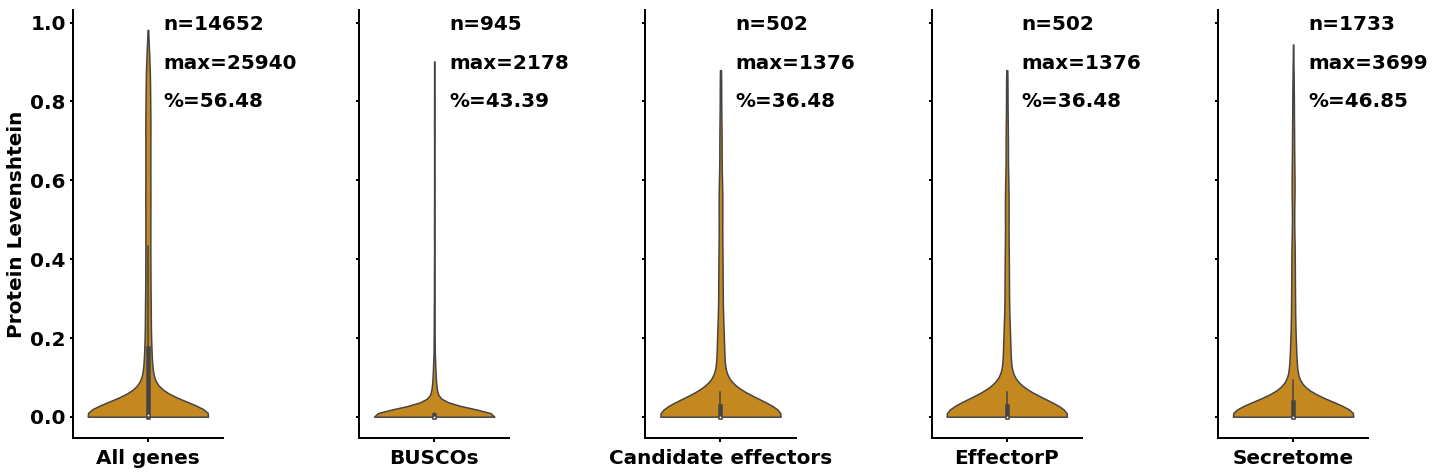

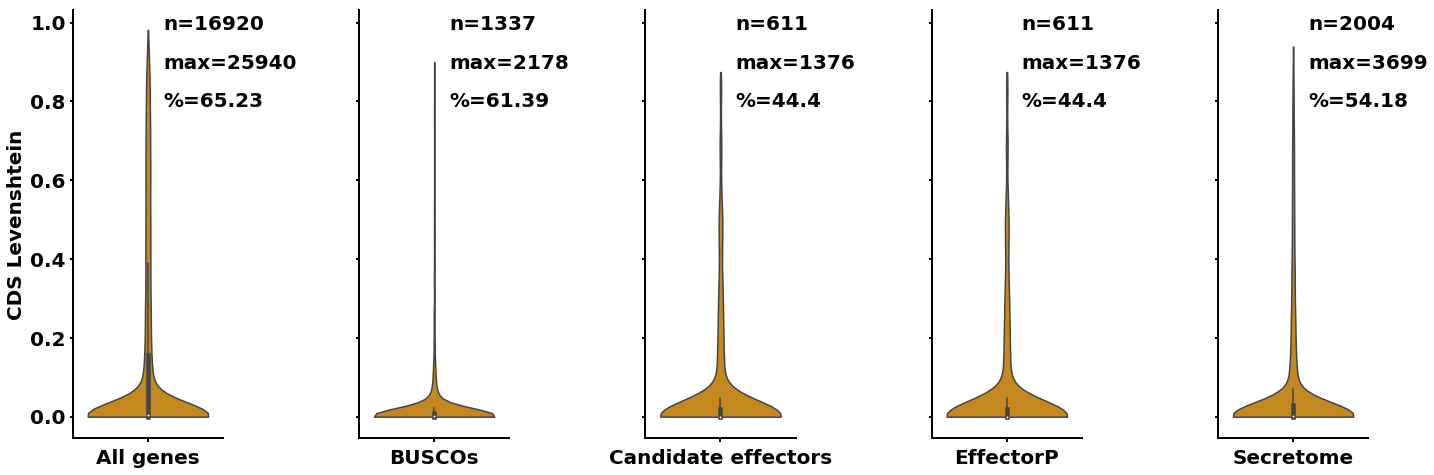

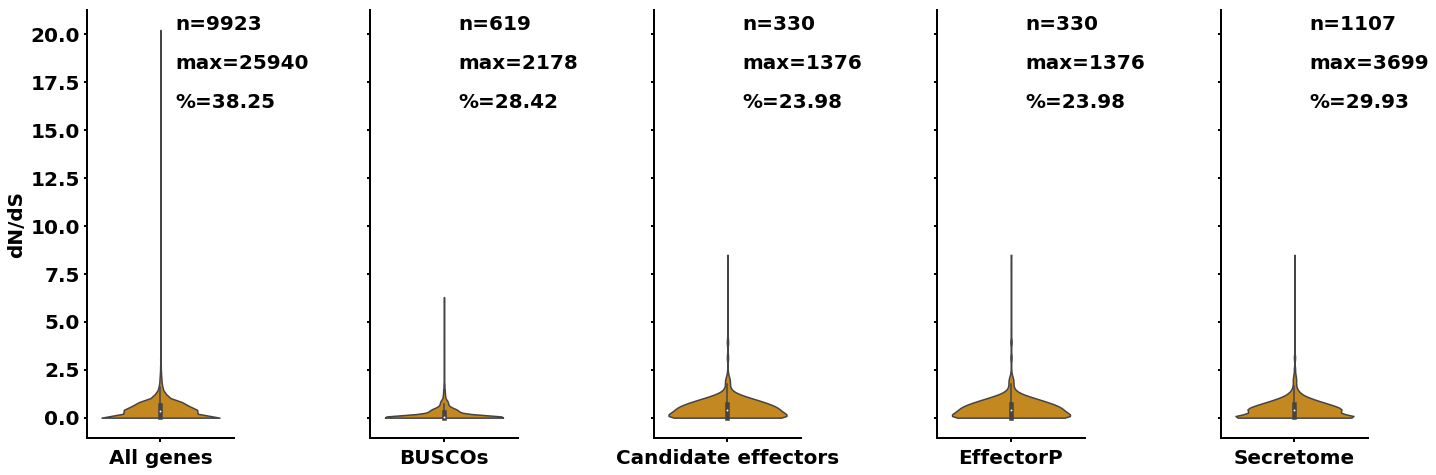

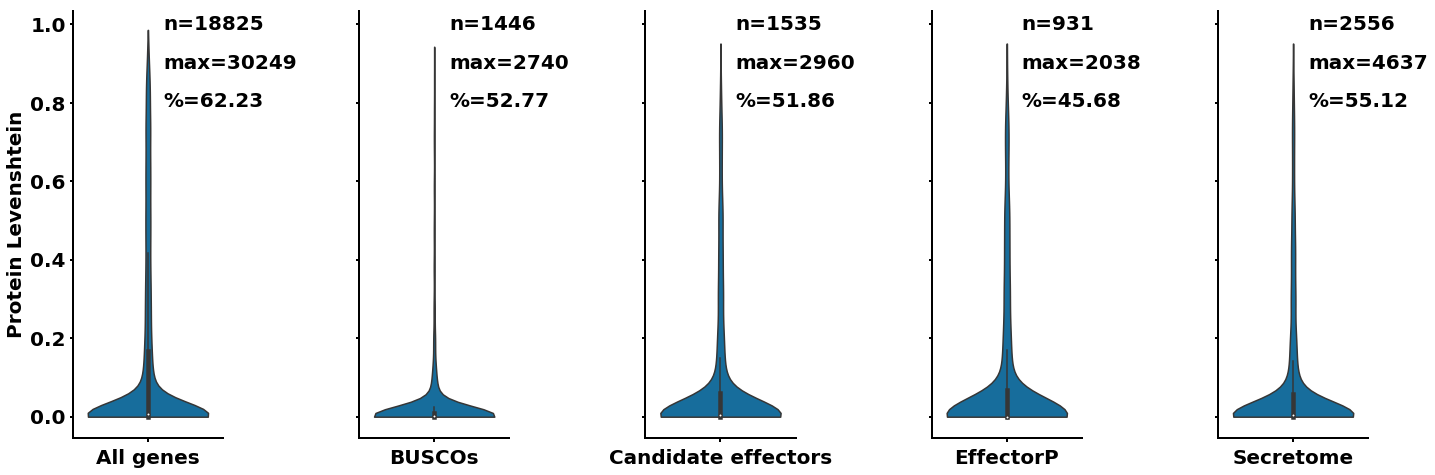

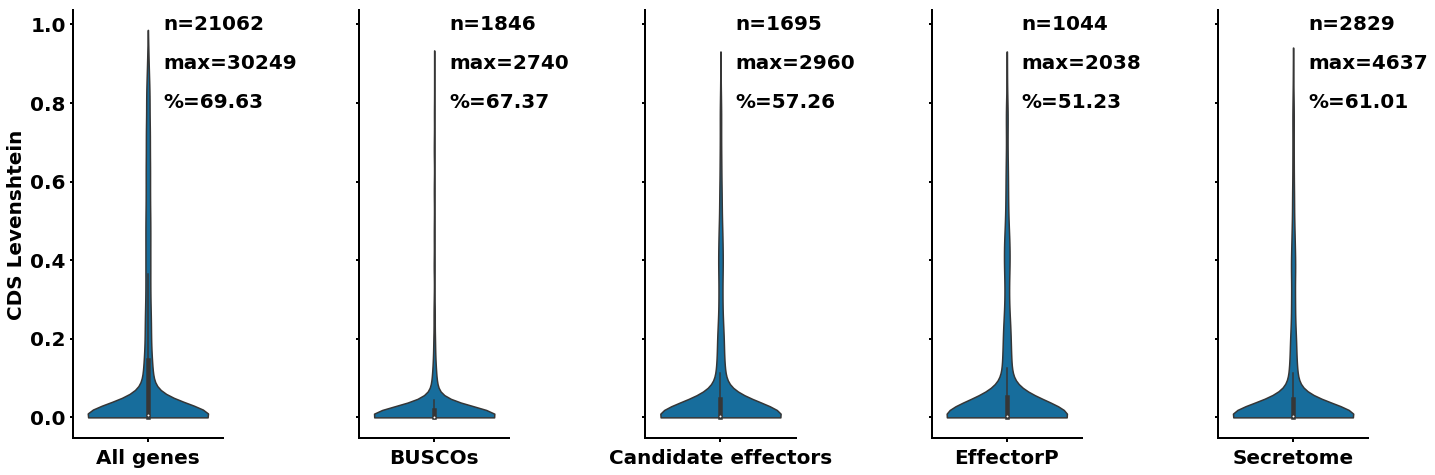

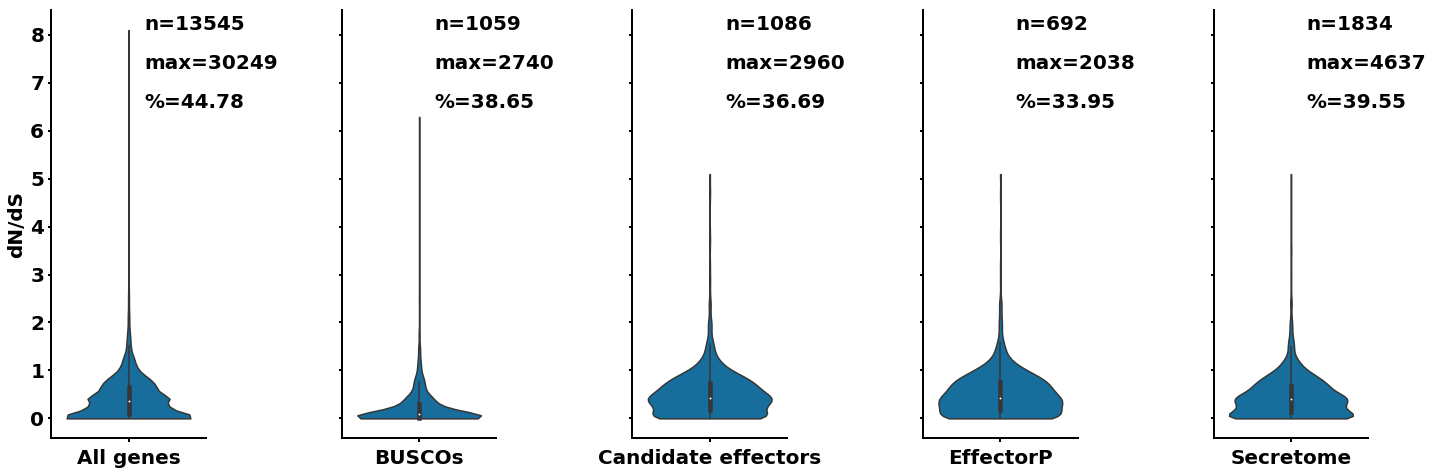

In [45]:
pallete = [sns.color_palette('colorblind')[x] for x in [1,0]]

#needs fixing for the n calculation
#think about variation and synteny block length or gaps. This might be interesting.


for genome, color, genome_dict in zip(genomes, pallete, beddicts): 
    tmp_df = GENEMATCHDFDICT[genome]
    columns = [x for x in tmp_df.columns if x.startswith(genome + '_')]
    value_columns = ['protein_levenshtein','cds_levenshtein', 'yn00_dN/dS']
    for n, value in enumerate(value_columns):
        tmp_df_columns = []
        tmp_df_columns.append(genome)
        tmp_df_columns.append(value)
        tmp_df_columns.append('Match_type') 
        tmp_df_columns = tmp_df_columns + columns
        #tmp_df = tmp_df.loc[:, tmp_df_columns]
        #tmp_df = tmp_df[tmp_df.value]
        plot_variation(genome, tmp_df.loc[:, tmp_df_columns], value, y_axis_label_rename[value],  color, 'something')
        outfn = os.path.join(OUTPATH, 'F4_%s_%s_per_gene_group.tiff' % (genome, y_axis_label_rename[value].replace('/','over')))
        plt.savefig(outfn, dpi=600,bbox_inches='tight')

### TO-DO

* write a loop that does caluculate the p-values for the different tests and does multiple testing correction
* check what would be better for dN/dS
* Do top 30% variations and see if they are enriched in Candidate effectors or such.

In [119]:
GENEMATCHDFDICT

{'DK0911':              DK0911        Pst104E  protein_hamming  protein_levenshtein  \
 0      DK0911_11867  Pst104E_29665           0.0089               0.0089   
 1      DK0911_20900  Pst104E_00397           0.0127               0.0127   
 2      DK0911_25366  Pst104E_10548           0.3269               0.3269   
 3      DK0911_18001  Pst104E_11378           0.0209               0.0209   
 4      DK0911_16293  Pst104E_05628           0.4297               0.4297   
 5      DK0911_12938  Pst104E_08749           0.0629               0.0629   
 6      DK0911_29815  Pst104E_12994           0.7744               0.7744   
 7      DK0911_01374  Pst104E_08218           0.4586               0.4586   
 8      DK0911_07013  Pst104E_29502           0.0377               0.0377   
 9      DK0911_30684  Pst104E_10572           0.7308               0.7308   
 10     DK0911_28835  Pst104E_01926           0.8525               0.8525   
 11     DK0911_20104  Pst104E_09046           0.0108              

In [50]:
tmp_df = GENEMATCHDFDICT['DK0911']

In [52]:
tmp_df.columns

Index(['DK0911', 'Pst104E', 'protein_hamming', 'protein_levenshtein',
       'cds_hamming', 'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS',
       'LWL85m_dN/dS', 'LPB93_dN/dS', 'DK0911_All_genes', 'DK0911_Busco',
       'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome',
       'Pst104E_All_genes', 'Pst104E_Busco', 'Pst104E_Ceffectors',
       'Pst104E_EffectorP', 'Pst104E_Secretome', 'Match_type'],
      dtype='object')

In [ ]:
fisher_exact([[len(test_list[0]), len(test_list[1])], [len(expect_list[0]), len(expect_list[1])]])[1]

In [ ]:
fisher_exact

In [96]:
number_of_genes = tmp_df.shape[0]
cut_off = 0.4

In [97]:
tmp_df = tmp_df.fillna(0).sort_values('yn00_dN/dS', ascending=False).reset_index(drop=True)


In [117]:
selection_enrichment_dict = {}
selection_enrichment_dict['DK0911'] = {}
for cut_off in range(0,10):
    cut_off = cut_off/20
    key = 'cut_off_%s' % str(cut_off).replace('.','')
    selection_enrichment_dict['DK0911'][key] = []
    print('\n\n')
    print(cut_off)
    print('########')

    for gene_type in [ 'DK0911_All_genes', 'DK0911_Busco',
           'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome']:
        selection = int(tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0] * cut_off)
        print(gene_type)
        expected_list = [tmp_df[tmp_df['yn00_dN/dS'] > 0][gene_type].sum(),tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0] ]
        test_list = [tmp_df.iloc[:selection][gene_type].sum(), selection]
        print(expected_list)
        print(test_list)
        p_value = fisher_exact([[test_list[0],test_list[1] ], [expected_list[0], expected_list][1]])[1]
        print(p_value)




0.0
########
DK0911_All_genes
[9923, 9923]
[0, 0]
1.0
DK0911_Busco
[619, 9923]
[0, 0]
1.0
DK0911_Ceffectors
[330, 9923]
[0, 0]
1.0
DK0911_EffectorP
[330, 9923]
[0, 0]
1.0
DK0911_Secretome
[1107, 9923]
[0, 0]
1.0



0.05
########
DK0911_All_genes
[9923, 9923]
[496, 496]
1.0
DK0911_Busco
[619, 9923]
[15, 496]
0.0033640065547
DK0911_Ceffectors
[330, 9923]
[19, 496]
0.523570889444
DK0911_EffectorP
[330, 9923]
[19, 496]
0.523570889444
DK0911_Secretome
[1107, 9923]
[56, 496]
0.942118460107



0.1
########
DK0911_All_genes
[9923, 9923]
[992, 992]
1.0
DK0911_Busco
[619, 9923]
[27, 992]
4.18194602026e-06
DK0911_Ceffectors
[330, 9923]
[38, 992]
0.407510777577
DK0911_EffectorP
[330, 9923]
[38, 992]
0.407510777577
DK0911_Secretome
[1107, 9923]
[112, 992]
0.91634953925



0.15
########
DK0911_All_genes
[9923, 9923]
[1488, 1488]
1.0
DK0911_Busco
[619, 9923]
[38, 1488]
3.57684683923e-09
DK0911_Ceffectors
[330, 9923]
[64, 1488]
0.0686227471211
DK0911_EffectorP
[330, 9923]
[64, 1488]
0.0686227471211

In [118]:
selection_enrichment_dict = {}
selection_enrichment_dict['DK0911'] = {}
for cut_off in range(0,2):
    #cut_off = cut_off/20
    key = 'cut_off_%s' % str(cut_off).replace('.','')
    selection_enrichment_dict['DK0911'][key] = []
    print('\n\n')
    print(cut_off)
    print('########')

    for gene_type in [ 'DK0911_All_genes', 'DK0911_Busco',
           'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome']:
        selection = int(tmp_df[tmp_df['yn00_dN/dS'] > cut_off].shape[0])
        print(gene_type)
        expected_list = [tmp_df[tmp_df['yn00_dN/dS'] > 0][gene_type].sum(),tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0] ]
        test_list = [tmp_df.iloc[:selection][gene_type].sum(), selection]
        print(expected_list)
        print(test_list)
        p_value = fisher_exact([[test_list[0],test_list[1] ], [expected_list[0], expected_list][1]])[1]
        print(p_value)




0
########
DK0911_All_genes
[9923, 9923]
[9923, 9923]
1.0
DK0911_Busco
[619, 9923]
[619, 9923]
1.0
DK0911_Ceffectors
[330, 9923]
[330, 9923]
1.0
DK0911_EffectorP
[330, 9923]
[330, 9923]
1.0
DK0911_Secretome
[1107, 9923]
[1107, 9923]
1.0



1
########
DK0911_All_genes
[9923, 9923]
[1210, 1210]
1.0
DK0911_Busco
[619, 9923]
[32, 1210]
2.42205877946e-07
DK0911_Ceffectors
[330, 9923]
[51, 1210]
0.13253591761
DK0911_EffectorP
[330, 9923]
[51, 1210]
0.13253591761
DK0911_Secretome
[1107, 9923]
[144, 1210]
0.503450207936


In [120]:
tmp_df = GENEMATCHDFDICT['Pst104E']
tmp_df = tmp_df.fillna(0).sort_values('yn00_dN/dS', ascending=False).reset_index(drop=True)

In [122]:
#selection_enrichment_dict = {}
#selection_enrichment_dict['DK0911'] = {}
for cut_off in range(0,10):
    cut_off = cut_off/20
    key = 'cut_off_%s' % str(cut_off).replace('.','')
    #selection_enrichment_dict['DK0911'][key] = []
    print('\n\n')
    print(cut_off)
    print('########')

    for gene_type in [ 'Pst104E_All_genes', 'Pst104E_Busco', 'Pst104E_Ceffectors',
       'Pst104E_EffectorP', 'Pst104E_Secretome']:
        selection = int(tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0] * cut_off)
        print(gene_type)
        expected_list = [tmp_df[tmp_df['yn00_dN/dS'] > 0][gene_type].sum(),tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0] ]
        test_list = [tmp_df.iloc[:selection][gene_type].sum(), selection]
        print(expected_list)
        print(test_list)
        p_value = fisher_exact([[test_list[0],test_list[1] ], [expected_list[0], expected_list][1]])[1]
        print(p_value)




0.0
########
Pst104E_All_genes
[13545, 13545]
[0, 0]
1.0
Pst104E_Busco
[1059, 13545]
[0, 0]
1.0
Pst104E_Ceffectors
[1086, 13545]
[0, 0]
1.0
Pst104E_EffectorP
[692, 13545]
[0, 0]
1.0
Pst104E_Secretome
[1834, 13545]
[0, 0]
1.0



0.05
########
Pst104E_All_genes
[13545, 13545]
[677, 677]
1.0
Pst104E_Busco
[1059, 13545]
[32, 677]
0.00439522108424
Pst104E_Ceffectors
[1086, 13545]
[58, 677]
0.614418577417
Pst104E_EffectorP
[692, 13545]
[36, 677]
0.789124195072
Pst104E_Secretome
[1834, 13545]
[83, 677]
0.421914093001



0.1
########
Pst104E_All_genes
[13545, 13545]
[1354, 1354]
1.0
Pst104E_Busco
[1059, 13545]
[55, 1354]
5.3812401362e-07
Pst104E_Ceffectors
[1086, 13545]
[117, 1354]
0.466319298768
Pst104E_EffectorP
[692, 13545]
[77, 1354]
0.369347127511
Pst104E_Secretome
[1834, 13545]
[169, 1354]
0.360561726641



0.15
########
Pst104E_All_genes
[13545, 13545]
[2031, 2031]
1.0
Pst104E_Busco
[1059, 13545]
[73, 2031]
3.54060496508e-12
Pst104E_Ceffectors
[1086, 13545]
[194, 2031]
0.035210732841

In [123]:
for cut_off in range(0,2):
    #cut_off = cut_off/20
    key = 'cut_off_%s' % str(cut_off).replace('.','')
    #selection_enrichment_dict['DK0911'][key] = []
    print('\n\n')
    print(cut_off)
    print('########')

    for gene_type in [ 'Pst104E_All_genes', 'Pst104E_Busco', 'Pst104E_Ceffectors',
       'Pst104E_EffectorP', 'Pst104E_Secretome']:
        selection = int(tmp_df[tmp_df['yn00_dN/dS'] > cut_off].shape[0])
        print(gene_type)
        expected_list = [tmp_df[tmp_df['yn00_dN/dS'] > 0][gene_type].sum(),tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0] ]
        test_list = [tmp_df.iloc[:selection][gene_type].sum(), selection]
        print(expected_list)
        print(test_list)
        p_value = fisher_exact([[test_list[0],test_list[1] ], [expected_list[0], expected_list][1]])[1]
        print(p_value)




0
########
Pst104E_All_genes
[13545, 13545]
[13545, 13545]
1.0
Pst104E_Busco
[1059, 13545]
[1059, 13545]
1.0
Pst104E_Ceffectors
[1086, 13545]
[1086, 13545]
1.0
Pst104E_EffectorP
[692, 13545]
[692, 13545]
1.0
Pst104E_Secretome
[1834, 13545]
[1834, 13545]
1.0



1
########
Pst104E_All_genes
[13545, 13545]
[1513, 1513]
1.0
Pst104E_Busco
[1059, 13545]
[59, 1513]
3.27910285564e-08
Pst104E_Ceffectors
[1086, 13545]
[133, 1513]
0.347884363859
Pst104E_EffectorP
[692, 13545]
[92, 1513]
0.129067984565
Pst104E_Secretome
[1834, 13545]
[193, 1513]
0.477650570229


In [112]:
selection_enrichment_dict = {}
selection_enrichment_dict['DK0911'] = {}
for cut_off in range(0,5):
    cut_off = cut_off/20
    key = 'cut_off_%s' % str(cut_off).replace('.','')
    selection_enrichment_dict['DK0911'][key] = []
    print('\n\n')
    print(cut_off)
    print('########')

    for gene_type in [ 'DK0911_All_genes', 'DK0911_Busco',
           'DK0911_Ceffectors', 'DK0911_EffectorP', 'DK0911_Secretome']:
        selection = int(tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0] * cut_off)
        print(gene_type)
        print( tmp_df[tmp_df['yn00_dN/dS'] > 0][gene_type].sum()/tmp_df[tmp_df['yn00_dN/dS'] > 0].shape[0])
        print(tmp_df.iloc[:selection][gene_type].sum()/selection)
        




0.0
########
DK0911_All_genes
1.0
nan
DK0911_Busco
0.0623803285297
nan
DK0911_Ceffectors
0.0332560717525
nan
DK0911_EffectorP
0.0332560717525
nan
DK0911_Secretome
0.111559004333
nan



0.05
########
DK0911_All_genes
1.0
1.0
DK0911_Busco
0.0623803285297
0.0302419354839
DK0911_Ceffectors
0.0332560717525
0.0383064516129
DK0911_EffectorP
0.0332560717525
0.0383064516129
DK0911_Secretome
0.111559004333
0.112903225806



0.1
########
DK0911_All_genes
1.0
1.0
DK0911_Busco
0.0623803285297
0.0272177419355
DK0911_Ceffectors
0.0332560717525
0.0383064516129
DK0911_EffectorP
0.0332560717525
0.0383064516129
DK0911_Secretome
0.111559004333
0.112903225806



0.15
########
DK0911_All_genes
1.0
1.0
DK0911_Busco
0.0623803285297
0.0255376344086
DK0911_Ceffectors
0.0332560717525
0.0430107526882
DK0911_EffectorP
0.0332560717525
0.0430107526882
DK0911_Secretome
0.111559004333
0.122983870968



0.2
########
DK0911_All_genes
1.0
1.0
DK0911_Busco
0.0623803285297
0.0277217741935
DK0911_Ceffectors
0.03325607175

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in long_scalars


In [48]:
print('Hello')

Hello


In [46]:
GENEMATCHDFDICT[genome]

,Pst104E,DK0911,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS,...,DK0911_Busco,DK0911_Ceffectors,DK0911_EffectorP,DK0911_Secretome,Pst104E_All_genes,Pst104E_Busco,Pst104E_Ceffectors,Pst104E_EffectorP,Pst104E_Secretome,Match_type
0,Pst104E_18206,DK0911_30030,0.8480,0.8480,0.8423,0.8397,0.7592,0.7774,0.7307,0.7776,...,False,False,False,False,True,False,False,False,False,ortho
1,Pst104E_29488,DK0911_06256,0.2134,0.2134,0.1636,0.1616,0.3598,0.3006,0.3261,0.3828,...,False,False,False,False,True,False,False,False,False,ortho
2,Pst104E_25028,DK0911_13770,0.8104,0.8104,0.8104,0.8104,NaN,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho
3,Pst104E_28456,DK0911_12480,0.6893,0.6893,0.6610,0.6573,0.3860,0.3324,0.4684,0.3753,...,False,False,False,False,True,False,False,False,False,ortho
4,Pst104E_06991,DK0911_26923,0.7500,0.7500,0.7280,0.7198,0.2355,NaN,NaN,NaN,...,False,False,False,False,True,False,False,False,False,ortho
5,Pst104E_20069,DK0911_15427,0.5581,0.5548,0.5495,0.5441,0.3424,0.3069,0.3767,0.3791,...,False,False,False,False,True,False,False,False,False,ortho
6,Pst104E_28848,DK0911_16321,0.0005,0.0005,0.0003,0.0003,0.6000,0.2857,0.6000,0.4000,...,False,False,False,False,True,False,False,False,False,ortho
7,Pst104E_04514,DK0911_22088,0.3364,0.3318,0.3272,0.2673,1.0806,1.1575,1.5969,1.4923,...,False,False,False,False,True,False,False,False,False,ortho
8,Pst104E_30155,DK0911_06745,0.2043,0.2043,0.1921,0.1911,0.5778,0.5814,0.6919,0.6545,...,False,False,False,False,True,False,False,False,False,ortho
9,Pst104E_04800,DK0911_10785,0.0000,0.0000,0.0056,0.0056,-0.0000,0.0000,0.0000,0.0000,...,False,False,False,False,True,False,False,False,False,ortho


In [ ]:
def get_collinear_df(fn):
    """Parses out a dataframe from a collinear file obtained with synet runs.
    This is not universial right now but assumes that DK0911 is first in this file and Pst104 is
    second in this file."""

    synteny_dict = {}
    synteny_dict['aln_name'] = []
    synteny_dict['aln_position'] = []
    synteny_dict['aln_length'] = []
    synteny_dict['Pst104E'] = []
    synteny_dict['DK0911'] = []
    synteny_dict['distance_5'] = []
    synteny_dict['distance_3'] = []
    len_pattern = re.compile(r'N=([^ ]*)')
    d_pattern = re.compile(r'DK[^\t]*')
    p_pattern = re.compile(r'Pst[^\t]*')
    position_pattern = re.compile(r'-([^:]*)')
    count = 0
    with open(fn, 'r') as fh:
        for line in fh:
            line.rstrip()
            count = count + 1
            if line.startswith(r'## '):
                aln_len = int(re.findall(len_pattern, line)[0])
                aln_name = line.split(':')[0][3:]
            elif not line.startswith(r'#'):
                aln_position = int(re.findall(position_pattern , line)[0].replace(' ', ''))
                synteny_dict['DK0911'].append(re.findall(d_pattern, line)[0])
                synteny_dict['Pst104E'].append(re.findall(p_pattern, line)[0])
                synteny_dict['aln_name'].append(aln_name)
                synteny_dict['aln_length'].append(aln_len)
                synteny_dict['aln_position'].append(aln_position)
                synteny_dict['distance_5'].append(aln_position)
                synteny_dict['distance_3'].append(aln_len - aln_position)
    syn_df = pd.DataFrame.from_dict(synteny_dict)
    return syn_df

### Now add the longest synteny block for each gene

In [ ]:
def max_length(gene, genome, max_length_df):
    if len(max_length_df[max_length_df[genome] == gene]['aln_length']) > 0:
        return max_length_df[max_length_df[genome] == gene]['aln_length'].values[0]
    else:
        return np.nan

In [ ]:
syn_fn = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/run_SynNet/Genomes20190529_1333-SynNet-k500w0m9/DK_PAu.collinearity'

In [ ]:
syn_df = get_collinear_df(syn_fn)

In [ ]:
max_length_df_dict = {}
GENEMATCHDFDICTv2 = {}
for genome in genomes:
    tmp_df = GENEMATCHDFDICT[genome]
    idx = syn_df.groupby(genome)['aln_length'].agg(pd.Series.idxmax)
    max_length_df_dict[genome] = syn_df.iloc[idx].drop_duplicates([genome, 'aln_length']).copy()
    tmp_df_maxlength = max_length_df_dict[genome]
    tmp_df['Max_aln_length'] = tmp_df[genome].apply(lambda x: max_length(x, genome, tmp_df_maxlength))
    GENEMATCHDFDICTv2[genome] = tmp_df

In [ ]:
def plot_correlation(genome, df, values, genetype, filter_bed_fn, color, out_fn):
   
    
    f1, ax = plt.subplots(1, len(values), figsize=(20, 10), sharey=False)
    
    for n, value in enumerate(values):
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst104E':
            _dict = Pst_104E_dict
    
        
        sub_gene_list = get_gene_list(filter_bed_fn)
        df = df[df[genome].isin(sub_gene_list)].copy()
        df = df[df[genetype] == True].copy()
        df = df.reset_index(drop=True)
        sns.regplot(x='Max_aln_length', y=value, data=df, y_jitter=.05, x_estimator=np.mean, ci=None, ax=ax[n])
    

        index_array = df['Max_aln_length'].unique()
        index_array.sort()
        pearsonr_values = pearsonr(df.groupby('Max_aln_length')[value].mean(), index_array[:-1])
        print(pearsonr_values)
        #g.set(title='%s %s' % (genome, genetype)) 
        #ax[y[0], y[1]].axhline(y=overlap, color='r', linestyle='-')
        #ax[n].set_title(genetype, fontsize=16)
        #ax[y[0], y[1]].set_yticklabels([])
        ax[n].set_xlabel('Max_aln_length')
        ax[n].set_ylabel(value, fontsize=16)
        
        x_text_start_value = df['Max_aln_length'].max() - 150 
        y_text_start_value = df.groupby('Max_aln_length')[value].mean().max() * 0.7
        
        #print(y_text_start_value)
        
        ax[n].text(x_text_start_value, y_text_start_value,\
                   'R=%.3f\np-value=%.2E' % (pearsonr_values[0], pearsonr_values[1]))
        
        
        
        #ax[n].text(0.1, 0.9*y_text_start_value, 'max=%s' % max_genes)
        #percentage = round(df[(df[value] > 0)&(df[column] ==True) ].shape[0]/max_genes*100,2)
        #ax[n].text(0.1, 0.8*y_text_start_value, '%%=%s' % percentage)
    #ax[0].set_ylabel(value, fontsize=16)
    #ax[0].set_ylim(0, 400)
    plt.subplots_adjust(right=0.3, left=0.1)
    f1.suptitle(genetype)
    plt.tight_layout()
    #f1.suptitle(os.path.basename(out_fn))
    #plt.savefig(out_fn, dpi =300)
    #sns.despine(g)
    
    return f1

In [ ]:
def plot_correlation_qcut(genome, df, values, genetype, filter_bed_fn, color, out_fn):
    import matplotlib
    font = {'family' : 'normal',
            'weight' : 'regular',
            'size'   : 14}

    matplotlib.rc('font', **font)
    
    f1, ax = plt.subplots(1, len(values), figsize=(20, 10), sharey=False)
    
    for n, value in enumerate(values):
        if genome == 'DK0911':
            _dict = DK0911_dict
        elif genome =='Pst104E':
            _dict = Pst_104E_dict
    
        
        sub_gene_list = get_gene_list(filter_bed_fn)
        df = df[df[genome].isin(sub_gene_list)].copy()
        df = df[df[genetype] == True].copy()
        df = df.reset_index(drop=True)
        df.dropna(inplace=True)
        
        
        df['Max_length_category'] = pd.qcut(df.Max_aln_length, q= 40, duplicates= 'drop')
        mid_points = [x.mid for x in df.groupby('Max_length_category')[value].mean().index]
        interval_means = df.groupby('Max_length_category')[value].mean()
        interval_medians = df.groupby('Max_length_category')[value].median()
        
        #print(pearsonr(interval_medians, mid_points))
        sns.regplot(x=mid_points, y=interval_means, ax=ax[n])
        #sns.regplot(x=mid_points, y=interval_medians, y_jitter=.05,\
                        #x_estimator=np.mean, ci=None)

        pearsonr_values = pearsonr(interval_means, mid_points)
        print(pearsonr_values)
        ax[n].set_xlabel('Max synteny block length')
        ax[n].set_ylabel(value, fontsize=16)
        
        x_text_start_value = np.max(mid_points) - 150 
        y_text_start_value = interval_means.max() * 0.9
        
        
        ax[n].text(x_text_start_value, y_text_start_value,\
                   'R=%.3f\np-value=%.2E' % (pearsonr_values[0], pearsonr_values[1]), fontsize=16)
        
    plt.subplots_adjust(right=0.3, left=0.1)
    f1.suptitle(genetype)
    plt.tight_layout()

    
    return f1

In [ ]:
value_columns = ['protein_hamming', 'protein_levenshtein',
       'cds_hamming', 'cds_levenshtein', 'yn00_dN/dS', 'LWL85_dN/dS',
       'LWL85m_dN/dS', 'LPB93_dN/dS']

In [ ]:
#this approach wasn't correct as the data points are not weight according to sample size. e.g. each point
#representing about the same sample size (qcut does this.)
for genome, genome_dict in zip(genomes, beddicts):
    value_columns = [ 'cds_levenshtein', 'protein_levenshtein', 
       'LWL85m_dN/dS']

    for genetype in gene_keys:
        genetype = '%s_%s' % (genome, genetype)
        tmp_df = GENEMATCHDFDICTv2[genome]
        tmp_df_columns = []
        tmp_df_columns.append(genome)
        tmp_df_columns = tmp_df_columns + value_columns
        tmp_df_columns.append(genetype)
        tmp_df_columns.append('Max_aln_length')
        print(genetype, value)
        #print(pearsonr(tmp_df.Max_aln_length, tmp_df[value]))
        plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],value_columns, genetype,\
                             genome_dict["Primary_genes"],  color, 'something')

In [ ]:
for genome, genome_dict in zip(genomes, beddicts):
    value_columns = [ 'cds_levenshtein', 'protein_levenshtein', 
       'LWL85m_dN/dS']

    for genetype in gene_keys:
        genetype = '%s_%s' % (genome, genetype)
        tmp_df = GENEMATCHDFDICTv2[genome]
        tmp_df_columns = []
        tmp_df_columns.append(genome)
        tmp_df_columns = tmp_df_columns + value_columns
        tmp_df_columns.append(genetype)
        tmp_df_columns.append('Max_aln_length')
        print(genetype, value)
        #print(pearsonr(tmp_df.Max_aln_length, tmp_df[value]))
        plot_correlation_qcut(genome, tmp_df.loc[:, tmp_df_columns],value_columns, genetype,\
                             genome_dict["Primary_genes"],  color, 'something')

### Test coding below.

In [ ]:
genome = "DK0911"
value = 'LPB93_dN/dS'
genetype = 'DK0911_All_genes'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
#print(pearsonr(tmp_df.Max_aln_length, tmp_df[value]))
plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                 DK0911_dict["Primary_genes"],  color, 'something')

In [ ]:
genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_EffectorP'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
print(pearsonr(tmp_df['Max_aln_length'], tmp_df[tmp_df[genetype]][value]))
plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                 Pst_104E_dict["Primary_genes"],  color, 'something')

In [ ]:

genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_EffectorP'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
print(pearsonr(tmp_df['Max_aln_length'], tmp_df[tmp_df[genetype]][value]))
plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                 Pst_104E_dict["Primary_genes"],  color, 'something')

In [ ]:
genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_Busco'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
print(pearsonr(tmp_df.groupby('Max_aln_length')[value].mean(), index_array[:-1]))
print(pearsonr(tmp_df['Max_aln_length'], tmp_df[tmp_df[genetype]][value]))
#plot_correlation(genome, tmp_df.loc[:, tmp_df_columns],[value], genetype,\
                # Pst_104E_dict["Primary_genes"],  color, 'something')

In [ ]:
df = tmp_df.loc[:, tmp_df_columns]
df.dropna(inplace=True)
genome = "Pst104E"
value = 'protein_levenshtein'
genetype = 'Pst104E_Busco'
tmp_df = GENEMATCHDFDICTv2[genome]
tmp_df_columns = []
tmp_df_columns.append(genome)
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length')
tmp_df = tmp_df[tmp_df[genetype]]
df['Max_length_category'] = pd.qcut(df.Max_aln_length, q= 60, duplicates='drop')
mid_points = [x.mid for x in df.groupby('Max_length_category')[value].mean().index]
interval_means = df.groupby('Max_length_category')[value].mean()
interval_medians = df.groupby('Max_length_category')[value].median()
print(mid_points)
print(pearsonr(interval_means, mid_points))
print(pearsonr(interval_medians, mid_points))
sns.regplot(x=mid_points, y=interval_means,\
                    ci=None)

In [ ]:
df.groupby('Max_length_category')[value].count()

In [ ]:
tmp_list = df.protein_levenshtein.unique().tolist()
tmp_list.sort()
tmp_list

In [ ]:
mid_points = [x.mid for x in df.groupby('Max_length_category')[value].mean().index]

In [ ]:
sns.regplot(x='Max_aln_length', y=value, data=tmp_df.loc[:, tmp_df_columns], y_jitter=.05,\
                    x_estimator=np.mean, ci=None)

In [ ]:
index_array = tmp_df['Max_aln_length'].unique()
index_array.sort()
index_array[:-1]

In [ ]:
tmp_df.groupby('Max_aln_length')[value].mean()

In [ ]:
value = 'yn00_dN/dS'
genetype = 'Pst104E_Busco'
tmp_df_columns = []
tmp_df_columns.append("Pst104E")
tmp_df_columns.append(value)
tmp_df_columns.append(genetype)
tmp_df_columns.append('Max_aln_length') 
plot_correlation("Pst104E", GENEMATCHDFDICTv2[genome].loc[:, tmp_df_columns],[value], genetype,\
                 Pst_104E_dict["Primary_genes"],  color, 'something')

In [ ]:
def max_length(gene, genome):
    if len(tmp_df_maxlength[tmp_df_maxlength[genome] == gene]['aln_length']) > 0:
        return tmp_df_maxlength[tmp_df_maxlength[genome] == gene]['aln_length'].values[0]
    else:
        return np.nan

In [ ]:
tmp_df['Max_aln_length']

In [ ]:
tmp_df_maxlength.head()

In [ ]:
tmp_df.head()

In [ ]:
tmp_df_maxlength[tmp_df_maxlength[genome] == 'DK0911_00005']['aln_length'].values[0]

In [ ]:
print('hello')

In [ ]:
tmp_df[genome].apply(lambda x: tmp_df_maxlength[tmp_df_maxlength[genome] == 'Pst104E_18230']['aln_length'])

In [ ]:
tmp_df_maxlength[tmp_df_maxlength[genome] == 'Pst104E_18230']['aln_length']

In [ ]:
tmp_df_maxlength[tmp_df_maxlength[genome] == 'Pst104E_18206']

In [ ]:
GENEMATCHDFDICT[genome]

In [ ]:
tmp_df.head()aa

In [ ]:
tmp_df.Match_type.unique()

In [ ]:
addondf = pd.DataFrame(columns=tmp_df.columns)

In [ ]:
addondf[genome] = pd.Series(list(missing_genes))

In [ ]:
addondf

In [ ]:
missing_genes = set(get_gene_list(bed_dict['All_genes'])) - set(tmp_df[genome].unique()) 

In [ ]:
len(missing_genes) 

In [ ]:
list(missing_genes)

In [ ]:
dict(zip(['Query', 'Target'], [genome, genomes[-1]] ))

In [ ]:
tmp_df.rename(columns= dict(zip(['Query', 'Target'], [genome, genomes[-1]] )))